# DNR Fire Response Times
Within the agency's fire occurrence reporting system (EIRS), data is stored regarding each fire's 'start' datetime and each fire's 'first attack' datetime. The 'start' time is the time the fire was reported to the local dispatch office and keyed into the dispatch system. The 'first attack' time is the time when resources first arrived on scene and engaged the fire. From these two datetimes, we can compute the response time of DNR assets to a wildfire. The median response time could be a useful performance metric for reporting to the Office of Financial Management annually alongside number of fires, burned area, and suppression costs. 

**1. Import helpful libraries**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

**2. Read in dataset from EIRS**

In [2]:
fires_df = pd.read_csv('eirs_data.csv')
fires_df.head(2)

,Incident Name,Incident Number,Classification,Region,County,Final Total Acres,Type of Date,General Cause,Specific Cause,Specific Sub Cause,Date,Time
0,NO BONAPARTE,884,False Alarm,NORTHEAST,Okanogan County,NaN,Started,Undetermined,None,None,06/09/20,15:06
1,DOMINION TREE,208,Classified,NORTHEAST,Stevens County,0.1,Started,Lightning,None,None,06/08/20,14:25


**3. Begin cleaning the data**

a. Convert date and time columns to one column containing datetime objects:

In [3]:
fires_df['Date'] = pd.to_datetime(fires_df['Date'] + ' ' + fires_df['Time'])

b. Only get 2008 to 2019 fires

In [4]:
fires_df = fires_df[(fires_df['Date'].dt.strftime('%Y-%m-%d') >= '2008-01-01') & (fires_df['Date'].dt.strftime('%Y-%m-%d') <= '2019-12-31')]
fires_df.head(2)

,Incident Name,Incident Number,Classification,Region,County,Final Total Acres,Type of Date,General Cause,Specific Cause,Specific Sub Cause,Date,Time
753,DAYBOB,54,False Alarm,OLYMPIC,Jefferson County,NaN,Started,Undetermined,None,None,2019-12-04 09:47:00,9:47
754,TAYLOR MOUNTAIN,150,Classified,SO PUGET,King County,0.1,Started,Recreation,Day Use,Other,2019-11-17 10:45:00,10:45


c. Filter and assemble masks of dataframe for date types and classified fires

In [5]:
start_records = fires_df[(fires_df['Type of Date'] == 'Started')]
attack_records = fires_df[(fires_df['Type of Date'] == 'First Attack')]

d. Merge dataframes based on Incident Name and Incident Number

In [6]:
df = pd.merge(start_records, attack_records, on=['Incident Name', 'Incident Number'])
df.head(2)

,Incident Name,Incident Number,Classification_x,Region_x,County_x,Final Total Acres_x,Type of Date_x,General Cause_x,Specific Cause_x,Specific Sub Cause_x,...,Classification_y,Region_y,County_y,Final Total Acres_y,Type of Date_y,General Cause_y,Specific Cause_y,Specific Sub Cause_y,Date_y,Time_y
0,TAYLOR MOUNTAIN,150,Classified,SO PUGET,King County,0.1,Started,Recreation,Day Use,Other,...,Classified,SO PUGET,King County,0.1,First Attack,Recreation,Day Use,Other,2019-11-17 14:00:00,14:00
1,41 VISTA,153,Classified,PACIFIC CASC,Wahkiakum County,0.1,Started,Undetermined,None,None,...,Classified,PACIFIC CASC,Wahkiakum County,0.1,First Attack,Undetermined,None,None,2019-11-16 08:20:00,8:20


e. Get rid of extra columns created by merge

In [7]:
# Columns were determined to have same values as 'x' dataset or be only slightly different
df = df.drop(columns=['Classification_y', 'Region_y', 'County_y', 'Time_x', 'Time_y', 'General Cause_y', 
                      'Specific Cause_y', 'Specific Sub Cause_y', 'Final Total Acres_y'])

f. Filter out errors in reporting where dispatch either flipped the date/times or miskeyed:

In [8]:
df = df[df['Date_y'] >= df['Date_x']]

**4. Calculate response time**

In [9]:
df['response_minutes'] = (df['Date_y'] - df['Date_x']).dt.seconds / 60

a. Remove those that have response minutes = 0. Unsure why this could happen, perhaps if resources discovers the fire/responds simultaneously? 


In [10]:
df = df[df['response_minutes'] > 0]
df.head(2)

,Incident Name,Incident Number,Classification_x,Region_x,County_x,Final Total Acres_x,Type of Date_x,General Cause_x,Specific Cause_x,Specific Sub Cause_x,Date_x,Type of Date_y,Date_y,response_minutes
0,TAYLOR MOUNTAIN,150,Classified,SO PUGET,King County,0.1,Started,Recreation,Day Use,Other,2019-11-17 10:45:00,First Attack,2019-11-17 14:00:00,195.0
1,41 VISTA,153,Classified,PACIFIC CASC,Wahkiakum County,0.1,Started,Undetermined,None,None,2019-11-15 18:00:00,First Attack,2019-11-16 08:20:00,860.0


b. Let's add year, month, and day, and then remove those fires which were reported but responded to on the next day. These fires are removed as they result in many outliers since response times would be crazy high. This is likely because wildfires are mostly very unsafe to respond to at night and must wait until the morning to be engaged. 

In [11]:
df['year'] = df['Date_x'].dt.strftime('%Y')
df['month'] = df['Date_x'].dt.strftime('%m')
df['day_x'] = df['Date_x'].dt.strftime('%d')
df['day_y'] = df['Date_y'].dt.strftime('%d')

df1 = df[df['day_x'] == df['day_y']]

c. Searching for outliers

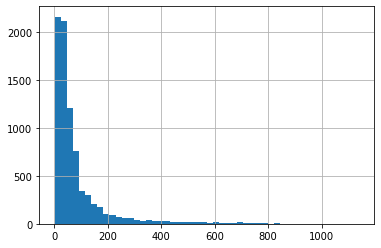

In [12]:
df1['response_minutes'].hist(bins=50)

In [13]:
df1['response_minutes'].mean()

84.14942528735632

d. Response times are heavily right-tailed. Let's remove outliers by eliminating records with response times 3 standard deviations from mean

In [14]:
df1 = df1[((df1['response_minutes'] - df1['response_minutes'].mean()) / df1['response_minutes'].std()).abs() < 3]

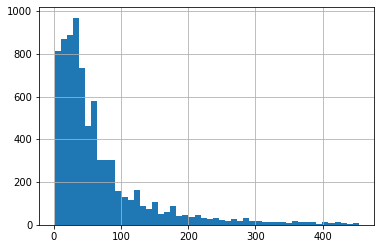

In [15]:
df1['response_minutes'].hist(bins=50)

In [16]:
df1['response_minutes'].mean()

67.4924252068746

e. Much better, now examining data by regions, years, etc. 

What is the median response time by region over the period?

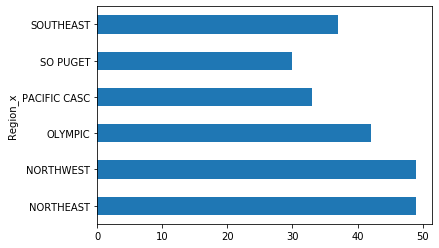

In [17]:
df1.groupby(['Region_x'])['response_minutes'].median().plot.barh()

What is the median response time across all regions over each year?

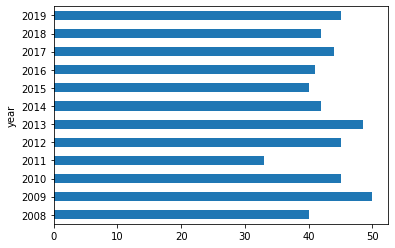

In [18]:
df1.groupby(['year'])['response_minutes'].median().plot.barh()

What is the median response time by fire cause?
Interesting that lightning fires have such a high response time, likely because they occur moreso in complex/inaccessible terrain...

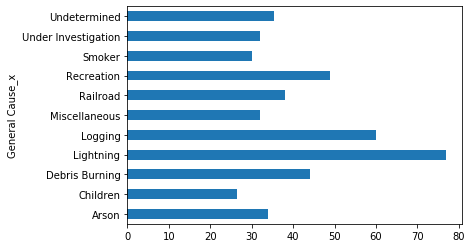

In [19]:
df1.groupby(['General Cause_x'])['response_minutes'].median().plot.barh()

What is the median response time by month?

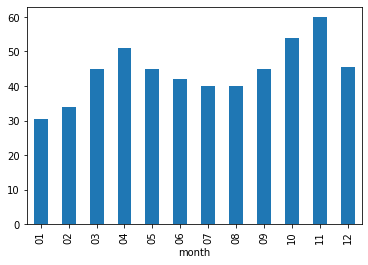

In [20]:
df1.groupby(['month'])['response_minutes'].median().plot.bar()

What is the response time by county in Pacific Cascade Region?

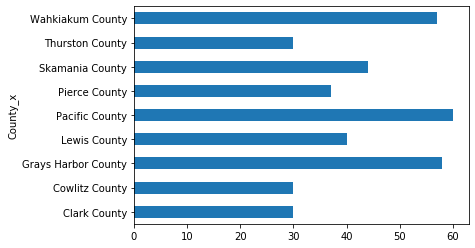

In [21]:
df_pcs = df1[df1['Region_x'] == 'PACIFIC CASC']
df_pcs.groupby(['County_x'])['response_minutes'].median().plot.barh()

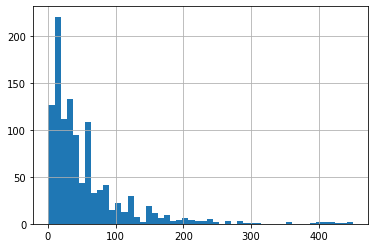

In [22]:
df_pcs['response_minutes'].hist(bins=50)

What is the bottom line here? 

In [23]:
print('The median response time for DNR varies from {} min in SPS Region to {} min in NES Region'.format(
    min(df1.groupby(['Region_x'])['response_minutes'].median()), 
    max(df1.groupby(['Region_x'])['response_minutes'].median())))

The median response time for DNR varies from 30.0 min in SPS Region to 49.0 min in NES Region


Response times for lightning are much higher than all other causes, and response times are highest during the months of April, November, and December, likely due to dead, fine fuels and a lack of seasonal resources to respond. 